<a href="https://colab.research.google.com/github/bettyttytty/Replicate-paper-result/blob/main/A_Closer_Look_at_Accuracy_vs_Robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/yangarbiter/robust-local-lipschitz
# https://arxiv.org/abs/2003.02460

In [1]:
%%capture
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display
import pickle
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rc('text', usetex=True)

import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
import numpy as np
import torch
import torch.utils.data as data_utils
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

# from lolip.models.torch_utils.archs import *
# from lolip.variables import auto_var
# from params import *
# from utils import params_to_dataframe

fontsize=24
!pip install adversarial-robustness-toolbox
from art.utils import load_dataset, get_file, check_and_transform_label_format
from tensorflow.keras.datasets import cifar10

In [2]:
def get_nearest_oppo_dist(X, y, tstX, tsty, norm, n_jobs=10):
    if len(X.shape) > 2:
        X = X.reshape(len(X), -1)
        tstX = tstX.reshape(len(tstX), -1)
    p = norm

    def helper(yi):
        return NearestNeighbors(n_neighbors=1, metric='minkowski', p=p, n_jobs=2).fit(X[y != yi])
    nns = Parallel(n_jobs=n_jobs)(delayed(helper)(yi) for yi in np.unique(y))
    ret = np.zeros(len(X))
    tst_ret = np.zeros(len(tstX))
    for yi in np.unique(y):
        dist, _ = nns[yi].kneighbors(X[y==yi], n_neighbors=1)
        ret[np.where(y==yi)[0]] = dist[:, 0]
        
        dist, _ = nns[yi].kneighbors(tstX[tsty==yi], n_neighbors=1)
        tst_ret[np.where(tsty==yi)[0]] = dist[:, 0]

    return nns, ret, tst_ret

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
(x_train, y_train_onehot), (x_test, y_test_onehot), min_, max_ = load_dataset(str("mnist"))
x_train = x_train.transpose(0, 3, 1, 2).astype("float32")
x_test = x_test.transpose(0, 3, 1, 2).astype("float32")
y_train_onehot = np.float32(y_train_onehot)
y_test_onehot = np.float32(y_test_onehot)
y_train = np.argmax(y_train_onehot, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)


In [ ]:
nns_linf, mnist_dists_linf, tst_mnist_dists_linf = get_nearest_oppo_dist(x_train, y_train, x_test, y_test, np.inf, n_jobs=1)
print(mnist_dists_linf.min(), mnist_dists_linf.mean())
print(tst_mnist_dists_linf.min(), tst_mnist_dists_linf.mean())

0.7372549027204514 0.989558824099158
0.8117647022008896 0.9896345103697386


(0.0, 1.0)

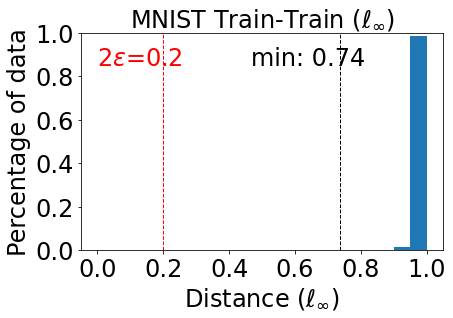

In [ ]:
# train to different train class
plt.figure(figsize=(6.5, 4))
plt.title("MNIST Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = mnist_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))
plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()-0.27, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.1
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.2, 0.85, '2$\epsilon$={:.1f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

# plt.tight_layout()
# plt.savefig("./figs/dataset_dist/mnist_linf_hist.png", format="png")
# plt.savefig("./figs/dataset_dist/mnist_linf_hist.pdf", format="pdf")

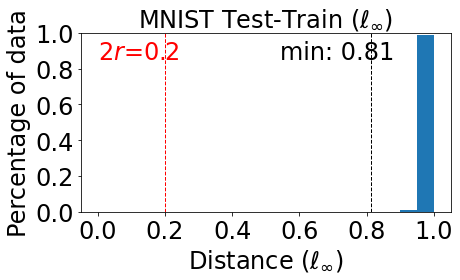

In [ ]:
# test to different train class
plt.figure(figsize=(6.5, 4))
plt.title("MNIST Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
data = tst_mnist_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))
plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()-0.27, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.1
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.2, 0.85, '2$r$={:.1f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)


plt.tight_layout()
# plt.savefig("./figs/dataset_dist/mnist_test_linf_hist.png", format="png")
# plt.savefig("./figs/dataset_dist/mnist_test_linf_hist.pdf", format="pdf")

In [3]:
def get_nearest_same_dist(X, y, tstX, tsty, norm, n_jobs=10):
    if len(X.shape) > 2:
        X = X.reshape(len(X), -1)
        tstX = tstX.reshape(len(tstX), -1)
    p = norm

    def helper(yi):
        return NearestNeighbors(n_neighbors=1, metric='minkowski', p=p, n_jobs=2).fit(X[y == yi])
    nns = Parallel(n_jobs=n_jobs)(delayed(helper)(yi) for yi in np.unique(y))
    ret = np.zeros(len(X))
    tst_ret = np.zeros(len(tstX))
    for yi in np.unique(y):
        dist, _ = nns[yi].kneighbors(X[y==yi], n_neighbors=1)
        ret[np.where(y==yi)[0]] = dist[:, 0]
        
        dist, _ = nns[yi].kneighbors(tstX[tsty==yi], n_neighbors=1)
        tst_ret[np.where(tsty==yi)[0]] = dist[:, 0]

    return nns, ret, tst_ret

In [36]:
nns_linf, mnist_dists_linf, tst_mnist_dists_linf = get_nearest_same_dist(x_train, y_train, x_test, y_test, np.inf, n_jobs=1)
print(mnist_dists_linf.min(), mnist_dists_linf.mean())
print(tst_mnist_dists_linf.min(), tst_mnist_dists_linf.mean())

0.0 0.0
0.2901960611343384 0.9024003939110786


(0.0, 1.0)

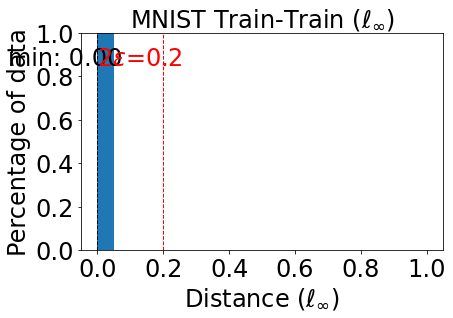

In [37]:
# train to same train class
plt.figure(figsize=(6.5, 4))
plt.title("MNIST Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = mnist_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))
plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()-0.27, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.1
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.2, 0.85, '2$\epsilon$={:.1f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

# plt.tight_layout()
# plt.savefig("./figs/dataset_dist/mnist_linf_hist.png", format="png")
# plt.savefig("./figs/dataset_dist/mnist_linf_hist.pdf", format="pdf")

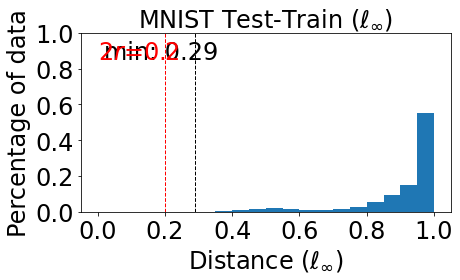

In [38]:
# test to same train class
plt.figure(figsize=(6.5, 4))
plt.title("MNIST Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
data = tst_mnist_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))
plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()-0.27, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.1
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.2, 0.85, '2$r$={:.1f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)


plt.tight_layout()
# plt.savefig("./figs/dataset_dist/mnist_test_linf_hist.png", format="png")
# plt.savefig("./figs/dataset_dist/mnist_test_linf_hist.pdf", format="pdf")

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = (x_train.astype("float32"))/255
x_test = (x_test.astype("float32"))/255
y_train = y_train.reshape(1,-1)[0]
y_test = y_test.reshape(1,-1)[0]

170508288/170498071 [==============================] - 2s 0us/step


In [8]:
# nns_linf, cifar_dists_linf, tst_cifar_dists_linf = get_nearest_oppo_dist(x_train, y_train, x_test, y_test, np.inf, n_jobs=1)
print(cifar_dists_linf.min(), cifar_dists_linf.mean())
print(tst_cifar_dists_linf.min(), tst_cifar_dists_linf.mean())

0.21176472306251526 0.4794814213450812
0.2196078523993492 0.4793200097392779


In [12]:

f=open('/content/drive/MyDrive/diff.pkl','rb')
cifar_dists_linf, tst_cifar_dists_linf = pickle.load(f)
f.close()

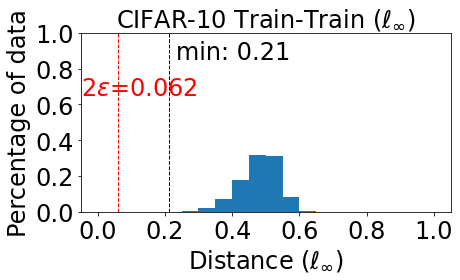

In [13]:
# train to different train class
plt.figure(figsize=(6.5, 4))
plt.title("CIFAR-10 Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = cifar_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.031
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.11, 0.65, '2$\epsilon$={:.3f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)


plt.tight_layout()
# plt.savefig("./figs/dataset_dist/cifar10_linf_hist.png", format="png")
# plt.savefig("./figs/dataset_dist/cifar10_linf_hist.pdf", format="pdf")

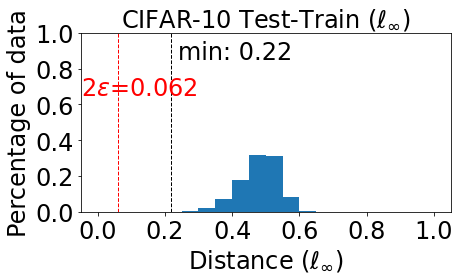

In [14]:
# test to different train class
plt.figure(figsize=(6.5, 4))
plt.title("CIFAR-10 Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = tst_cifar_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.031
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.11, 0.65, '2$\epsilon$={:.3f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
# plt.savefig("./figs/dataset_dist/cifar10_test_linf_hist.png", format="png")
# plt.savefig("./figs/dataset_dist/cifar10_test_linf_hist.pdf", format="pdf")

In [ ]:
# nns_linf, cifar_dists_linf, tst_cifar_dists_linf = get_nearest_same_dist(x_train, y_train, x_test, y_test, np.inf, n_jobs=1)
print(cifar_dists_linf.min(), cifar_dists_linf.mean())
print(tst_cifar_dists_linf.min(), tst_cifar_dists_linf.mean())

In [15]:

f=open('/content/drive/MyDrive/same.pkl','rb')
cifar_dists_linf, tst_cifar_dists_linf = pickle.load(f)
f.close()

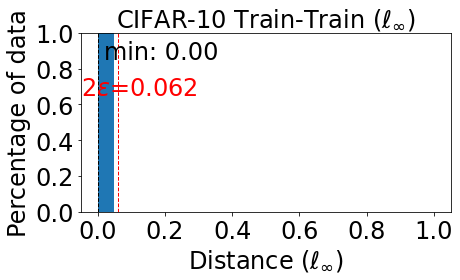

In [16]:
# train to same train class
plt.figure(figsize=(6.5, 4))
plt.title("CIFAR-10 Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = cifar_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.031
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.11, 0.65, '2$\epsilon$={:.3f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)


plt.tight_layout()
# plt.savefig("./figs/dataset_dist/cifar10_linf_hist.png", format="png")
# plt.savefig("./figs/dataset_dist/cifar10_linf_hist.pdf", format="pdf")

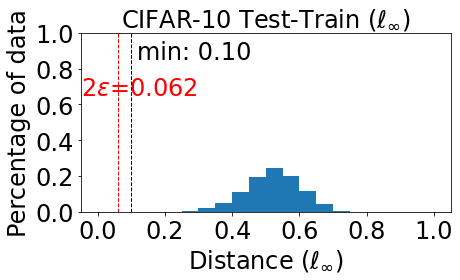

In [17]:
# test to same train class
plt.figure(figsize=(6.5, 4))
plt.title("CIFAR-10 Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = tst_cifar_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.031
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.11, 0.65, '2$\epsilon$={:.3f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
# plt.savefig("./figs/dataset_dist/cifar10_test_linf_hist.png", format="png")
# plt.savefig("./figs/dataset_dist/cifar10_test_linf_hist.pdf", format="pdf")